# Masked RCNN
Adapting the model from here https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py

In [1]:
from fastai.vision import *
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

![FPN](https://cdn-images-1.medium.com/max/1600/1*D_EAjMnlR9v4LqHhEYZJLg.png)

Subsequent usage of the words <b>downsampling</b> and <b>upsampling</b> paths refer to the bottom-up and top-down pathway respectively from the above diagram.

In [2]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.Px_conv1 = conv2d(ch_lat, ch, ks=1, bias=True)
#         self.Px_conv2 = conv2d(ch, cs, ks=3, padding=0, bias=True)
            
    def forward(self, x):
        #Run a 1x1conv on the features from the downsampling path, upsample the output from P(x-1)
        res = self.Px_conv1(self.hook.stored) + nn.functional.interpolate(x, scale_factor=2)
        return res

##### Note to self
Intend to explore whether or not stride 2 conv is better than maxpooling (P5 - P6).

In [3]:
class FPN(nn.Module):
    """
    Creates upsampling path by hooking activations from the downsampling path. Tested on ResNet50.
    
    INPUT:
        encoder: Default ResNet50
        chs: Number of intermediate channels to use between convolutions
    
    RETURNS:
        [p2,p3,p4,p5,p6]: [Tensor]
    """
    def __init__(self, encoder:nn.Module, chs:int) -> [Tensor]:
    
        super().__init__()
        
        #This runs dummy data through the encoder to get the right channel numbers after each layer C1 through C5
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        
        #Attaching hooks to the relevant layers C2 to C5 so we can get their activations during the
        #upsampling path
        self.encoder = encoder
        
        #The link between C5 and P5
        #TODO: will a stride 2 conv be better?
        self.c5_p5 = nn.Sequential(
            conv2d(sfs_szs[-1][1], chs, ks=1, bias=True),
        )
        
        
#         self.p5_conv2 = nn.Sequential(
#             nn.ZeroPad2d(1),
#             conv2d(chs,chs,ks=3,padding=0,bias=True)
#         )
        self.p5_conv2 = conv2d(chs,chs,ks=3,bias=True)
        
        #Link between P5 and P6
        self.p5_p6 = nn.MaxPool2d(kernel_size=1, stride=2)
        
        #These are the idxs of C4, C3, and C2 respectively
        idx  = list(reversed(sfs_idxs[-2:-5:-1]))
        self.sfs = hook_outputs([encoder[i] for i in idx])
        
        #This handles the mapping from P5 -> P4 -> P3 -> P2
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(idx, self.sfs)])
        
        #One final conv to smoothen things out after the merge
        self.final_convs = [conv2d(chs, chs, ks=3, stride=1, bias=True) for _ in idx+[1]]
           
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5_p5(c5.clone())]
        #Mapping P5 through P2 one by one
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
         
        #Extra convs after the lateral upsampling
        for i, conv in enumerate(self.final_convs):
            p_states[i] = conv(p_states[i])
            
        #Doing P6 at the end
        p6 = self.p5_p6(p_states[-1])
        p_states += [p6]
        return p_states
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [4]:
x = torch.randn(10,3,448,448)

In [5]:
fpn = FPN(create_body(models.resnet50,pretrained=False),256)

In [6]:
fpnres = fpn(x)

In [7]:
shapes = [fpnres[0].shape,fpnres[1].shape,fpnres[2].shape,fpnres[3].shape,fpnres[4].shape]
shapes = [(s[-2],s[-1]) for s in shapes]
shapes

[(112, 112), (56, 56), (28, 28), (14, 14), (7, 7)]

In [8]:
#Find stride of model at each stage
dims = [s[-1] for s in shapes]
stride = [int(x.shape[-1]/d) for d in dims]

In [9]:
stride

[4, 8, 16, 32, 64]

In [10]:
3*112*112

37632

# Anchor Generation

Some hyperparameters.

In [11]:
# Length of square anchor side in pixels, we might need to play with this
RPN_ANCHOR_SCALES = (32, 64, 128, 256,350)

# Ratios of anchors at each cell (width/height)
# A value of 1 represents a square anchor, and 0.5 is a wide anchor
RPN_ANCHOR_RATIOS = [0.5, 1, 2]

# Anchor Stride
# Set to 1 so that anchor is given to every grid on the feature map
RPN_ANCHOR_STRIDE = 1

# The strides of each layer of the FPN Pyramid as calculated above.
BACKBONE_STRIDES = [4, 8, 16, 32, 64]

#Shape of each feature map as calculated above
BACKBONE_SHAPES = shapes

#To test things out
scales = RPN_ANCHOR_SCALES[0]
feature_stride = BACKBONE_STRIDES[0]
anchor_stride = RPN_ANCHOR_STRIDE
shape =BACKBONE_SHAPES[0]

In [12]:
# Get all combinations of scales and ratios
scales, ratios = np.meshgrid(np.array(scales), np.array(RPN_ANCHOR_RATIOS))
scales = scales.flatten()
ratios = ratios.flatten()

In [13]:
scales

array([32, 32, 32])

In [14]:
ratios

array([0.5, 1. , 2. ])

In [15]:
heights = scales / np.sqrt(ratios)
widths = scales * np.sqrt(ratios)

This seems to cover the entire area.

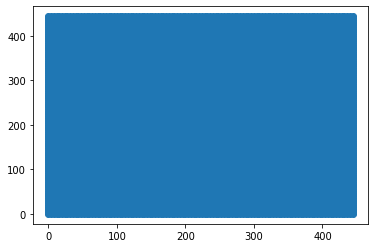

In [16]:
shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)
#We have covered every single possible point on a 256*256 IMG
plt.scatter(shifts_x,shifts_y)

In [17]:
def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: (Num anchors, 4). All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

In [474]:
anchors = generate_pyramid_anchors(RPN_ANCHOR_SCALES,RPN_ANCHOR_RATIOS,BACKBONE_SHAPES,BACKBONE_STRIDES,RPN_ANCHOR_STRIDE)

In [475]:
anchors.shape

(50127, 4)

## Ignoring Anchors That Are Out of Bounds
Might want to implement that since the Faster-RCNN paper suggests the following:

The anchor boxes that cross image boundaries need to be handled with care. During training, we ignore all cross-boundary anchors so they do not contribute to the loss. For a typical 1000 x 600 image, there will be roughly 20000 (60 x 40 x 9) anchors in total. With the cross-boundary anchors ignored, there are about 6000 anchors per image for training. If the boundary-crossing outliers are not ignored in training, they introduce large, difficult to correct error terms in the objective, and training does not converge. During testing, however, we still apply the fully convolutional RPN to the entire image. This may generate cross- boundary proposal boxes, which we clip to the image boundary.

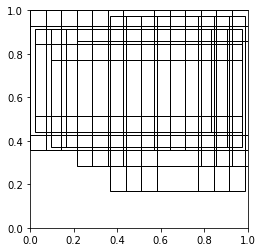

In [20]:
from random import shuffle
idx = np.random.randint(0,len(anchors),50)
sample_boxes = anchors[49750:49850]

# sample_boxes  = sample_boxes.clip(min=0,max=448)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
for b in sample_boxes:
    #Since matplotlib expects something to be between 0 and 1
    y1, x1, y2, x2 = b/448
    if y1 < 0 or x1 <0 : continue
    if y2 > 1 or x2 > 1: continue
    x = x2-x1;
    y=y2-y1
    ax.add_patch(
         patches.Rectangle(
            (x1,y1),x,y,
            fill=False      # remove background
         ) )     

### Region Proposal Network

#### Lack of dropout
Just noticed the lack of dropout in this model. Might be worth checking into.

In [21]:
class RPN(nn.Module):
    """Builds the model of Region Proposal Network.
    
    Inputs:
        anchors_per_location: number of anchors per pixel in the feature map
        anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                       every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_logits: [batch, H, W, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, W, W, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H, W, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """

    def __init__(self, ratios_per_anchor=3, anchor_stride=1, ch_in=256):
        super(RPN, self).__init__()
        self.ratios_per_anchor = ratios_per_anchor
        self.anchor_stride = anchor_stride
        self.ch_in = ch_in
        #This conv has a 'same' padding so that grid size does not change
        self.conv_shared = conv2d(ch_in,512,ks=3,stride=anchor_stride,bias=True)
        self.relu = nn.ReLU(inplace=True)
        
        #Since we will have anchors of various ratios at each position on the featuregrid, 
        #we need that many predictions
        #Class predicts whether or not an anchor has a match
        #BBox predicts the corresponding coordinates
        self.conv_class = conv2d(512,2 * ratios_per_anchor,ks=1,stride=anchor_stride,bias=True)
        self.softmax = nn.Softmax(dim=2)
        self.conv_bbox = nn.Conv2d(512, 4 * ratios_per_anchor, kernel_size=1, stride=1)
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = self.relu(self.conv_shared(x))
        
        ###Classification - Absence/Presence of Match
        # (bs,2*numratios,h,w)
        class_logits = self.conv_class(x)
        
        # bs, h, w, 2*ratios
        class_logits = class_logits.permute(0,2,3,1)
        class_logits = class_logits.contiguous()
        # (bs, num anchors, 2)
        class_logits = class_logits.view(x.size()[0], -1, 2)
        
        ###Bounding Box Regressor
        bbox = self.conv_bbox(x)
        # (bs, h, w, 4*ratios)
        bbox = bbox.permute(0,2,3,1)
        bbox = bbox.contiguous()
        # (bs, num anchors, 4)
        bbox = bbox.view(x.size()[0], -1, 4)
                
        return [class_logits, bbox]


Identifying regions of interest

In [22]:
rpn = RPN()

In [23]:
# Loop through pyramid layers
layer_outputs = []  # list of lists
for p in fpnres:
    layer_outputs.append(rpn(p))

outputs = list(zip(*layer_outputs))
outputs = [torch.cat(list(o), dim=1) for o in outputs]
rpn_class_logits, rpn_bbox = outputs

# Near Maximum Suppression (NMS)
This removes bounding boxes that have high overlap with each other (prioritises boxes that the model is more confident in).

In [24]:
def hard_nms(bboxes, scores, topn=2000, iou_thresh=0.7):
    # Perhaps top 2000 for training and 1000 for inference
    indices = scores.argsort()
    bboxes = bboxes[indices]
    final_results = []

    res = bboxes

    while len(res)!=0:
        box = res[-1]
        final_results.append(box)
        if len(final_results) == topn:
            return torch.stack(final_results,0)
        res = res[:-1]

        start_max = np.maximum(res[:, 0:2], box[0:2])
        end_min = np.minimum(res[:, 2:4], box[2:4])
        lengths = end_min - start_max
        intersec_map = lengths[:, 0] * lengths[:, 1]
        intersec_map[np.logical_or(lengths[:, 0] < 0, lengths[:, 1] < 0)] = 0
        iou_map_cur = intersec_map / ((res[:, 2] - res[:, 0]) * (res[:, 3] - res[:, 1]) + (box[2] - box[0]) * (
            box[3] - box[1]) - intersec_map +1e-16)
        res = res[iou_map_cur < iou_thresh]

    return np.array(cdd_results)

Some helper functions to calculate IoU.

In [25]:
def intersection(inputs, targets):
    """    
    Compute the sizes of the intersections of `inputs` with `targets`.
    Inputs:
        inputs,targets in (y1,x1,y2,x2) form
    """
    i, t = inputs.size(0), targets.size(0)
    inputs, targets = inputs.unsqueeze(1).expand(i,t,4), targets.unsqueeze(0).expand(i,t,4)
    bottom_left = torch.max(inputs[...,:2], targets[...,:2])
    top_right = torch.min(inputs[...,2:], targets[...,2:])
    sizes = torch.clamp(top_right - bottom_left, min=0) 
    return sizes[...,0] * sizes[...,1]

In [26]:
def IoU_values(inputs, targets):
    "Compute the IoU values of `inputs` with `targets`."
    inter = intersection(inputs, targets)
    input_sz = (inputs[:,2] - inputs[:,0]) * (inputs[:,3] - inputs[:,1])
    target_sz = (targets[:,2] - targets[:,0]) * (targets[:,3] - targets[:,1])
    union = input_sz.unsqueeze(1) + target_sz.unsqueeze(0) - inter
    iou = inter/(union+1e-8)
    #This way we filter out boxes that have zero areas
#     iou[input_sz == 0] = 1.
    return iou

In [27]:
#this is faster than above
def nms(b, s, topn=2000, thresh=0.75):
    """
    Inputs:
        b: tensor of boxes (numbox,4)
        s: tensor of scores (numbox,)
        thres: threshold of NMS
    """
    idx_sort = s.argsort(descending=True)
    boxes, scores = b[idx_sort], s[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0 :
        to_keep.append(idx_sort[indexes[0]])
        cdd = boxes[0]
        boxes, scores, indexes  = boxes[1:],scores[1:], indexes[1:]
        if len(boxes)==0:
            break
        iou_vals = IoU_values(boxes, cdd.unsqueeze(0)).squeeze()
        mask_keep = iou_vals < thresh
        if mask_keep.nonzero().shape[0] == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return to_keep[:topn]


Made this more legible.

In [32]:
# def preds2bbox(deltas,boxes):
#     """Applies the given deltas to the given boxes.
#     boxes: [N, 4] where each row is y1, x1, y2, x2
#     deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
#     """
# #     import pdb; pdb.set_trace()
#     # Convert to y, x, h, w
#     height = tensor(boxes[:, 2] - boxes[:, 0]).float()
#     width = tensor(boxes[:, 3] - boxes[:, 1]).float()
#     center_y = tensor(boxes[:, 0]).float() + 0.5 * height
#     center_x = tensor(boxes[:, 1]).float() + 0.5 * width
#     # Apply deltas
#     center_y += deltas[:, 0] * height
#     center_x += deltas[:, 1] * width
#     height *= torch.exp(deltas[:, 2])
#     width *= torch.exp(deltas[:, 3])
#     # Convert back to y1, x1, y2, x2
#     y1 = center_y - 0.5 * height
#     x1 = center_x - 0.5 * width
#     y2 = y1 + height
#     x2 = x1 + width
#     result = torch.stack([y1, x1, y2, x2], dim=1)
#     return result

def preds2bbox(deltas,boxes):
    """Applies the given deltas to the given boxes.
    boxes: [N, 4] where each row is y1, x1, y2, x2
    deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
    """
    hw = boxes[...,2:]-boxes[...,:2]
    center_yx = (boxes[...,2:]+boxes[...,:2])*0.5
    hw_ = hw.clone() * deltas[...,:2]
    center_yx += hw_
    hw *= torch.exp(deltas[...,2:])
    y1x1 = center_yx - 0.5 * hw
    y2x2 = center_yx + 0.5 * hw
    result = torch.cat([y1x1,y2x2],-1)

    return result

# Needs work!
We can't parallelise this, so we process each item in the batch one-by-one.

In [29]:
def process_1_proposal(inputs, anchors, imgsize=(448,448),nms_threshold=0.7, max_proposals=2000):
    """
    Handles one proposal only.
    Receives anchor offets and confidence scores and selects candidates to move on to the next stage. 
    Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. 

    Inputs:
        rpn_probs: [batch, anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """
    # Remove batch dimension
    inputs[0] = inputs[0].squeeze(0)
    inputs[1] = inputs[1].squeeze(0)

    # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
    scores = F.softmax(inputs[0],-1)[:, 1]

    # Box Offsets [num_anchors, 4]
    offsets = inputs[1]
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    std_dev = tensor(RPN_BBOX_STD_DEV)[None,:]
    if torch.cuda.is_available():
        std_dev = std_dev.cuda()
    offsets = offsets * std_dev.float()

    # Improve performance by trimming to top anchors by score
    # and doing the rest on the smaller subset.
    pre_nms_limit = min(6000, anchors.shape[0])
    scores, order = scores.sort(descending=True)
    order = order[:pre_nms_limit]
    scores = scores[:pre_nms_limit]
    offsets = offsets[order.data, :] 
    anchors = tensor(anchors[order.data, :]).float()
    
    # Apply deltas to anchors to get refined anchors.
    # [num anchors, (y1, x1, y2, x2)]
    boxes = preds2bbox(offsets,anchors)

    # Clip to image boundaries. [num anchors, (y1, x1, y2, x2)]
    height, width = imgsize
    # ok we make the assumption that the images are square
    boxes = boxes.clamp(min=0,max=height)
    #
    keep_idx = nms(boxes, scores, topn=max_proposals, thresh=nms_threshold)

    return normalize_boxes(boxes[keep_idx], imgsize)

### We have to loop through to convert activations to BB coords and run NMS.
This step is a little slow, needs improvement.

In [30]:
bs = 10

Normalise the boxes so that they are between 0 and 1.

In [33]:
height,width = 448,448

In [34]:
def normalize_boxes(boxes, img_sz=(448,448)):
    height,width = img_sz
    norm = tensor([height, width, height, width]).float()
    res = boxes / norm
    return res

In [35]:
# %time normalize_boxes(boxes).shape

### Creating Training Targets
We get 2000 proposals after applying NMS on RPN proposals, we need to match them to ground truth targets.

The paper recommends only training on a certain amount of ROIs only, i.e. those that pass the threshold. It also recommends to have a pos:neg ratio of 1:3.

In [36]:
TRAIN_ROIS_PER_IMAGE = 200
ROI_POSITIVE_RATIO = 0.33
#We will perturb the targets slightly for regularisation purposes
BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

In [39]:
b2 = tensor([[2,180,200,300],[300,25,350,50]]).float()

### This works for batchsize one only.

In [66]:
def create_training_targets(proposals, gt_class_ids, gt_boxes):
    """
    Matches proposed ROIs with Ground Truth BBoxes and Labels based on IoU.
    """
    # Currently only supports batchsize 1
    proposals = proposals.squeeze(0)
    gt_class_ids = gt_class_ids.squeeze(0).int()
    gt_boxes = gt_boxes.squeeze(0)
    
    #Find IoU values between proposed boxes and target boxes
    overlaps = IoU_values(proposals,gt_boxes)
    #Find out which target box matches each proposed box best.
    roi_iou_max = torch.max(overlaps, dim=1)[0]
    
    # 1. Positive ROIs are those with >= 0.5 IoU with a targ box
    positive_roi_bool = roi_iou_max >= 0.5

    if positive_roi_bool.sum()>0:
        positive_indices = torch.nonzero(positive_roi_bool)[:, 0]

        positive_count = int(TRAIN_ROIS_PER_IMAGE *
                             ROI_POSITIVE_RATIO)
        rand_idx = torch.randperm(positive_indices.size()[0])
        rand_idx = rand_idx[:positive_count]
        if torch.cuda.is_available():
            rand_idx = rand_idx.cuda()

        positive_indices = positive_indices[rand_idx]
        positive_count = positive_indices.size()[0]
        positive_rois = proposals[positive_indices.data,:]

        positive_overlaps = overlaps[positive_indices.data,:]
        roi_gt_box_assignment = torch.max(positive_overlaps, dim=1)[1]
        roi_gt_boxes = gt_boxes[roi_gt_box_assignment.data,:]
        roi_gt_class_ids = gt_class_ids[roi_gt_box_assignment.data]

        offsets = find_offsets(positive_rois.data, roi_gt_boxes.data)
        std_dev = torch.from_numpy(BBOX_STD_DEV).float()
        if torch.cuda.is_available():
            std_dev = std_dev.cuda()
        offsets /= std_dev
    else:
        # if we don't find any matches
        positive_count = 0
        
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_roi_bool = roi_iou_max < 0.5
    if negative_roi_bool.sum()>0 and positive_count>0:
        #Sample negative examples in a fixed ratio
        negative_indices = torch.nonzero(negative_roi_bool)[:, 0]
        r = 1.0 / ROI_POSITIVE_RATIO
        negative_count = int(r * positive_count - positive_count)
        rand_idx = torch.randperm(negative_indices.size()[0])
        rand_idx = rand_idx[:negative_count]
        if torch.cuda.is_available():
            rand_idx = rand_idx.cuda()
        negative_indices = negative_indices[rand_idx]
        negative_count = negative_indices.size()[0]
        negative_rois = proposals[negative_indices.data, :]
    else:
        negative_count = 0
            
    #PADDING
    # Append negative ROIs and pad box offsets with zeroes since they are disregarded during training.
    if positive_count > 0 and negative_count > 0:
        rois = torch.cat((positive_rois, negative_rois), dim=0)
        zeros = torch.zeros(negative_count).int()
        if torch.cuda.is_available():
            zeros= zeros.cuda()
        roi_gt_class_ids = torch.cat([roi_gt_class_ids, zeros], dim=0)
        zeros = torch.zeros(negative_count,4)
        if torch.cuda.is_available():
            zeros= zeros.cuda()
        offsets = torch.cat([offsets, zeros], dim=0)

    elif positive_count > 0:
        rois = positive_rois
    elif negative_count > 0:
        rois = negative_rois
        zeros = torch.zeros(negative_count).int()
        if torch.cuda.is_available():
            zeros= zeros.cuda()
        roi_gt_class_ids = zeros
        zeros = torch.zeros(negative_count,4)
        if torch.cuda.is_available():
            zeros= zeros.cuda()
        offsets = zeros
    else:
        rois =torch.FloatTensor()
        roi_gt_class_ids = torch.IntTensor()
        offsets = torch.FloatTensor()
        if torch.cuda.is_available():
            rois = rois.cuda()
            roi_gt_class_ids = roi_gt_class_ids.cuda()
            offsets = deltas.cuda()
    return rois, roi_gt_class_ids, offsets

In [417]:
def find_offsets(box, gt_box):
    """Calculate offsets needed to transform proposed ROI to Ground Truth Bounding Box.
    box and gt_box are [N, (y1, x1, y2, x2)]
    
    Returns:
     (nbox,4)
    """

    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = (box[:, 0] + 0.5 * height).float()
    center_x = (box[:, 1] + 0.5 * width).float()

    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width

    dy = (gt_center_y - center_y) / height.float()
    dx = (gt_center_x - center_x) / width.float()
    dh = torch.log(gt_height / height.float())
    dw = torch.log(gt_width / width.float())

    result = torch.stack([dy, dx, dh, dw], dim=1)
    return result

In [42]:
rois, target_class_ids, target_deltas = create_training_targets(tensor(anchors).float(),tensor([[1,2]]),b2)

In [43]:
mrcnn_feature_maps = fpnres[:-1]

In [44]:
POOL_SIZE = 7

In [45]:
inputs = [rois/448] + [m[0,:] for m in mrcnn_feature_maps]

In [46]:
def log2(x):
    """Implementatin of Log2. Pytorch doesn't have a native implemenation."""
    ln2 = torch.log(torch.FloatTensor([2.0]))
    if x.is_cuda:
        ln2 = ln2.cuda()
    return torch.log(x) / ln2

In [146]:
from roi_align.crop_and_resize import CropAndResize



In [47]:
from roi_align.crop_and_resize import CropAndResizeFunction
#Install from https://github.com/longcw/RoIAlign.pytorch

In [48]:
pool_size = 7

We've mentioned before (or did we) that each layer of the feature pyramid is responsible for detecting images of different sizes. Now that we have our RoIs, we can map them to the layer of the pyramid that they are supposed to be responsible for.

Formally, we assign an RoI of width w and height h (on the input image to the network) to the level P_k of our feature pyramid by:

Section 4.2, Equation 1 from https://arxiv.org/pdf/1612.03144.pdf

Analogous to the ResNet-based Faster R-CNN system that uses C4 as the single-scale feature map, we set k0 to 4

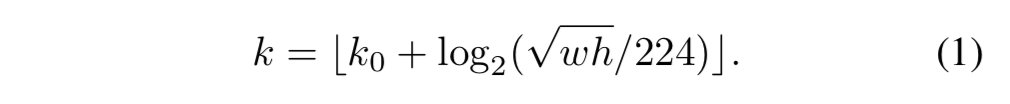

In [147]:
def pyramid_roi_align(inputs, image_shape:tuple,pool_size:int=7):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_size: [height, width] of the output pooled regions. Usually [7, 7]
    - image_shape: [height, width, channels]. Shape of input image in pixels

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized
             coordinates.
    - Feature maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, channels, height, width]

    Output:
    Pooled regions in the shape: [num_boxes, height, width, channels].
    The width and height are those specific in the pool_shape in the layer
    constructor.
    """

    # Currently only supports batchsize 1
    for i in range(len(inputs)):
        inputs[i] = inputs[i].squeeze(0)

    # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
    boxes = inputs[0]

    # Feature Maps. List of feature maps from different level of the
    # feature pyramid. Each is [batch, height, width, channels]
    feature_maps = inputs[1:]

    # Assign each ROI to a level in the pyramid based on the ROI area.
    y1, x1, y2, x2 = boxes.chunk(4, dim=1)
    h = y2 - y1
    w = x2 - x1

    # Equation 1 in the Feature Pyramid Networks paper. Account for
    # the fact that our coordinates are normalized here.
    # e.g. a 224x224 ROI (in pixels) maps to P4
    image_area = torch.FloatTensor([float(image_shape[0]*image_shape[1])])
    if boxes.is_cuda:
        image_area = image_area.cuda()
    roi_level = 4 + log2(torch.sqrt(h*w)/(224.0/torch.sqrt(image_area)))
    roi_level = roi_level.round().int()
    roi_level = roi_level.clamp(2,5)

    cropandresize = CropAndResize(7,7)
    # Loop through levels and apply ROI pooling to each. P2 to P5.  
    pooled = []
    box_to_level = []
    for i, level in enumerate(range(2, 6)):
        ix  = roi_level==level
        if not ix.any():
            continue
        ix = torch.nonzero(ix)[:,0]
        level_boxes = boxes[ix.data, :]

        # Keep track of which box is mapped to which level
        box_to_level.append(ix.data)

        # Stop gradient propogation to ROI proposals, this step will 
        level_boxes = level_boxes.detach()

        # Crop and Resize
        # We crop each feature map output from each level in the pyramid based on the RoIs that are assigned to them
        ind = torch.zeros(level_boxes.size()[0]).int()
        if level_boxes.is_cuda:
            ind = ind.cuda()
        feature_maps[i] = feature_maps[i].unsqueeze(0)  #CropAndResizeFunction needs batch dimension
        pooled_features = cropandresize(feature_maps[i], level_boxes, ind)
        pooled.append(pooled_features)

    # Pack pooled features into one tensor
    pooled = torch.cat(pooled, dim=0)

    # Pack box_to_level mapping into one array and add another
    # column representing the order of pooled boxes
    box_to_level = torch.cat(box_to_level, dim=0)

    # Rearrange pooled features to match the order of the original boxes
    _, box_to_level = torch.sort(box_to_level)
    pooled = pooled[box_to_level, :, :]

    return pooled

In [148]:
r = pyramid_roi_align(inputs,(448,448))

In [149]:
r.shape

torch.Size([178, 256, 7, 7])

We define the layer that handles classification and regression of each box.

In [56]:
def conv_bn_relu(ni, nf, ks):
    return nn.Sequential(conv2d(ni, nf, ks=ks, stride=1,padding=0,bias=True),
                         nn.BatchNorm2d(nf,eps=0.001, momentum=0.01), nn.ReLU(inplace=True))

In [236]:
class BBoxClassifierRegressor(nn.Module):
    def __init__(self, depth=256, pool_size:int=7, image_shape=(448,448), num_classes=12):
        super().__init__()
        self.depth = depth
        self.pool_size = pool_size
        self.image_shape = image_shape if isinstance(image_shape,tuple) else (image_shape,image_shape)
        self.num_classes = num_classes
        
        self.convs = nn.Sequential(conv_bn_relu(self.depth,1024,ks=self.pool_size),conv_bn_relu(1024,1024,ks=1))
        self.bbox_clas = nn.Linear(1024, num_classes)
        #HMM, can't we just do 4 instead of 4*classes
        self.bbox_reg = nn.Linear(1024, num_classes * 4)
    def forward(self, mrcnn_feature_maps , rois):
        x = pyramid_roi_align([rois]+mrcnn_feature_maps,self.image_shape, self.pool_size )
        x = self.convs(x)
        x = x.view(-1,1024)
        
        mrcnn_class_logits = self.bbox_clas(x)

        mrcnn_bbox = self.bbox_reg(x)
        mrcnn_bbox = mrcnn_bbox.view(mrcnn_bbox.size()[0], -1, 4)
        return [mrcnn_class_logits, mrcnn_bbox]

In [58]:
bbc = BBoxClassifierRegressor()

In [59]:
res = bbc([m[0,:] for m in mrcnn_feature_maps],rois/448)

In [60]:
res[0].shape

torch.Size([178, 12])

In [61]:
res[1].shape

torch.Size([178, 12, 4])

In [237]:
class MaskRCNN(nn.Module):
    """
    encoder : Tested on Resnet50 head. 
    pretrained : If we use a model from 'models', we can opt for a pretrained model
    chs: Number of intermediate dimensions
    num_classes: Number of output classes
    img_sz: Input image dimensions
    """
    def __init__(self, encoder=None, pretrained=True, chs=256, num_classes=20, img_sz = (448,448)):
        super().__init__()
        if not encoder:
            encoder = create_body(models.resnet50,pretrained=pretrained)
        
        self.img_sz = img_sz
            
        #Feature Pyramid Network
        self.fpn = FPN(encoder,chs)  
        
        #Create Anchor Boxes
        self.anchors = generate_pyramid_anchors(RPN_ANCHOR_SCALES,RPN_ANCHOR_RATIOS,BACKBONE_SHAPES,BACKBONE_STRIDES,RPN_ANCHOR_STRIDE)
#TODO: Turn this into PyTorch Tensors to use the GPU
#         if torch.cuda.is_available():
#             self.anchors = self.anchors.cuda()

        #Region Proposal Network
        self.rpn = RPN(ratios_per_anchor=len(RPN_ANCHOR_RATIOS),ch_in=chs)
        
        # BBox Classifier and Regressor
        self.bbox_clas_reg = BBoxClassifierRegressor(depth=chs, num_classes=num_classes)
        
    def forward(self,inp, targ=None):
        """
        A forward pass through the model should output the all predicted bounding boxes with their respective predicted classes.
        
        Target BBox should be normalised between 0 and 1
        """
        bs = inp.shape[0]
        if targ:
            gt_class_ids, gt_boxes = targ
        #Feed input through FPN
        #Returns : [p2_out, p3_out, p4_out, p5_out, p6_out]
        feature_maps = self.fpn(inp)
        #P6 not used in MRCNN layers
        mrcnn_feature_maps = feature_maps[:-1]
        
        #Loop through each feature map and feed it through the RPN
        layer_outputs = []  # list of lists
        for p in feature_maps:
            layer_outputs.append(self.rpn(p))
        
        # Concatenate layer outputs
        # e.g. [[logits1, bbox1], [logits2, bbox2]] => [[logits1,logits2], [bbox1, bbox2]]
        outputs = list(zip(*layer_outputs))
        outputs = [torch.cat(list(o), dim=1) for o in outputs]
        # We get logits that suggest whether or not an object is present, and the offsets to get the proposed region from the anchors
        rpn_class_logits, rpn_bbox = outputs
        
        
        #Proposal processing can't be done in a batch
        boxes = []
        for i in range(bs): boxes += [process_1_proposal([rpn_class_logits[i], rpn_bbox[i]], self.anchors, self.img_sz,nms_threshold=0.7, max_proposals=2000)]
        boxes = torch.stack(boxes) 

        if self.training:
            print('in training mode')
            #To save computation time, since we only sample some boxes to contribute to the loss, we do it here before running
            #subsequent computations.
            rois, target_class_ids,target_offsets = create_training_targets(boxes, gt_class_ids, gt_boxes)

            #If we get relevant detections
            if len(rois) > 0:
                mrcnn_class_logits, mrcnn_bbox = self.bbox_clas_reg(mrcnn_feature_maps,rois)
            else:
                mrcnn_class_logits = torch.FloatTensor()
                mrcnn_class = torch.IntTensor()
                mrcnn_bbox = torch.FloatTensor()
        
            return [rpn_class_logits, rpn_bbox, target_class_ids, mrcnn_class_logits, target_offsets, mrcnn_bbox]


In [238]:
x = torch.randn(1,3,448,448)

In [239]:
mrcnn = MaskRCNN()

In [240]:
res = mrcnn(x,(tensor([[1,2]]),b2/448))

in training mode


## Loss Functions
Now that we have a model that can make predictions. We need to define the loss functions (and a few targets). 
First, let's deal with the region proposals from the RPN. We predict a ton of anchors, but we only want a subset of them to be responsible for giving us a reasonable prediction.

More specifically, we assign the following:
1. If an anchor overlaps a GT box with IoU >= 0.7 then it's positive.
2. If an anchor overlaps a GT box with IoU < 0.3 then it's negative.
3. If an anchor is neither of the above, it is neutral and we ignore it.

Aside from that, we also want all GT boxes to be matched with something (even if it doesn't fulfill the IoU ratio). So at the end if there remains any GT box that hasn't been assigned to any anchor, we assign it to the closest anchor box.

In [248]:
gt_class_ids, gt_boxes = tensor([[1,2]]),b2/448

In [499]:
anchs = tensor(mrcnn.anchors/448).float()

In [426]:
#Hyperparameter that controls how many non-neutral boxes we have (neutral boxes get disregarded in the loss)
RPN_TRAIN_ANCHORS_PER_IMAGE = 256

In [516]:
def build_rpn_targets(anchors, gt_class_ids, gt_boxes):
    iou  = IoU_values(anchors,gt_boxes)
    rpn_match = torch.zeros(anchors.shape[0],dtype=torch.int32)

    #if the best IoU with all GT boxes are less than .3, its a negative
    values1, idx1  = iou.max(1)
    msk = torch.nonzero(values1<0.3)
    rpn_match[msk] = -1
    #if the best IoU is greater than .7, its a positive
    msk = torch.nonzero(values1>0.7)
    rpn_match[msk] = 1      
    #For each GT box, the anchor that has the highest overlap with it will be a positive no matter what
    values2, idx2  = iou.max(0)
    rpn_match[idx2] = 1
    
    #We don't want an imbalanced training regime
    #Check if positive exceeds the preset hyperparameter
    pos_ids = np.where(rpn_match == 1)[0]
    extra = len(pos_ids) - (RPN_TRAIN_ANCHORS_PER_IMAGE // 2)
    
    if extra > 0:
        # Reset the extra ones to neutral so they don't count
        ids = np.random.choice(ids, extra, replace=False)
        rpn_match[ids] = 0
        
    #Repeat for negatives
    neg_ids = np.where(rpn_match == -1)[0]
    extra = len(neg_ids) - (RPN_TRAIN_ANCHORS_PER_IMAGE -
                        torch.sum(rpn_match == 1).item())
    if extra > 0:
        # Rest the extra ones to neutral
        ids = np.random.choice(neg_ids, extra, replace=False)
        rpn_match[ids] = 0
    #Check again since we might have removed some positive examples    
    updated_pos_ids = np.where(rpn_match == 1)[0]
    
    #Negatives and neutrals with have zeroes as their bb targets
    rpn_bbox = torch.zeros((RPN_TRAIN_ANCHORS_PER_IMAGE, 4)).float()
    ix = 0 
    anchs,gts=[],[]
    for i, a in zip(updated_pos_ids, anchors[updated_pos_ids]):
        # idx1 contains the index of the GT box that fits that the ith anchor best
        gt = gt_boxes[idx1[i]]
        # Requires the batch dimension
        gt = gt.unsqueeze(0)
        # Find the offsets required to transform anchor to ground truth bb
        rpn_bbox[ix] = find_offsets(tensor(a).unsqueeze(0),gt)
    #     rpn_bbox[ix] /= RPN_BBOX_STD_DEV
        ix += 1
    return rpn_match, rpn_bbox